---

## **<font color="Dodgerblue"> Modelación Climática Tropical</font>**
### **<font color="crimson"> Mapas de las tendencias con regresión lineal para la precipitación en JJAS con SPEAR en los 3 primeros miembros y el promedio del ensamble</font>**


---

In [1]:
pip install xarray

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install cftime

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install h5netcdf

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install netCDF4 

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install h5py netCDF4 h5netcdf

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install cartopy

Note: you may need to restart the kernel to use updated packages.


In [7]:
import xarray as xr
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
from cartopy.util import add_cyclic_point
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import matplotlib.ticker as ticker
import glob

In [9]:
def lineplot_setup(xmin,xmax,xlab,ylab,ymin=None,ymax=None,title=None,legend=False):
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.grid(linestyle='--',alpha=0.66)
    plt.minorticks_on()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel(xlab,fontsize=14)
    plt.ylabel(ylab,fontsize=14)
    plt.title(title,fontsize=15)
    if legend:
        plt.legend(fancybox=True,shadow=True,fontsize=10)

In [44]:
def mapa_MC(data, levels, ccmap, titulo, extend='max', cbarlabel='pr  [mm day$^{-1}$]', 
            limite_NS=75, lon_min=None, lon_max=None, lat_min=None, lat_max=None):
    lons, lats = data.lon, data.lat
    data, lon = add_cyclic_point(data, coord=lons)
    fig = plt.figure(figsize=(12, 11))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    cs = ax.contourf(lon, lats, data, levels=levels, cmap=ccmap, extend=extend, transform=ccrs.PlateCarree())

    # Definimos la extensión del mapa
    if lon_min is not None and lon_max is not None and lat_min is not None and lat_max is not None:
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    else:
        ax.set_extent([0, 359.1, -limite_NS, limite_NS], crs=ccrs.PlateCarree())

    gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
    ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='k', linewidth=0.5)
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = {'size': 13}
    gl.ylabel_style = {'size': 13}
    plt.title(titulo, fontsize=22)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    # agregar colorbar
    cbar = plt.colorbar(cs, orientation='horizontal', fraction=0.046, pad=0.06)
    cbar.ax.xaxis.label.set_size(20)  
    cbar.ax.tick_params(labelsize=20)  
    cbar.ax.set_xlabel(cbarlabel)

In [11]:
# Archivo de precipitación SPEAR por miembro del ens
filename='/home/jovyan/ModClim/SPEAR3/monthly_ens001.nc'
ds=xr.open_dataset(filename)
pr=ds['precip']
pr

<xarray.DataArray 'precip' (time: 1080, lat: 90, lon: 104)> Size: 40MB
[10108800 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 9kB 1921-01-16T12:00:00 ... 2010-12-16T12:...
  * lon      (lon) float64 832B 235.3 235.9 236.6 237.2 ... 298.4 299.1 299.7
  * lat      (lat) float64 720B -0.75 -0.25 0.25 0.75 ... 42.75 43.25 43.75
Attributes:
    long_name:      Total precipitation rate
    units:          kg/m2/s
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  conserve_order1

In [12]:
# convirtiendo unidades
pr=pr*86400
pr['units']='mm day-1'

In [13]:
pr_years = pr.sel(time=slice('1921', '2010'))

In [14]:
jjas = pr_years.where((pr.time.dt.month >= 6) & (pr.time.dt.month <= 9), drop=True)

In [15]:
mean_jjas = jjas.mean('time')

### **<font color="Navy"> Serie de tiempo del promedio de área de las precipitaciones sobre el centro-sur de México </font>**


In [16]:
# Asignamos pesos con la función coseno
lats = jjas.lat
weights = np.cos(np.deg2rad(lats))
weights.name = "weights"

In [17]:
# Aplicamos el peso y luego el promedio espacial
pr_weighted = jjas.weighted(weights)
pr_meanglobal = pr_weighted.mean(dim=['lat', 'lon'])

In [18]:
# Recortamos México
centrolat=jjas.sel(lat=slice(9.25,33.25))
centrolon=centrolat.sel(lon=slice(242.75,275.75))

centro_peso=centrolon.weighted(weights)
prcentro=centrolon.mean(["lon","lat"])

pr_annual2=prcentro.resample(time='1Y').mean() # resampleo
#pr_annual2.to_netcdf('SPEAR_serie.nc')

/opt/conda/lib/python3.11/site-packages/xarray/groupers.py:509: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


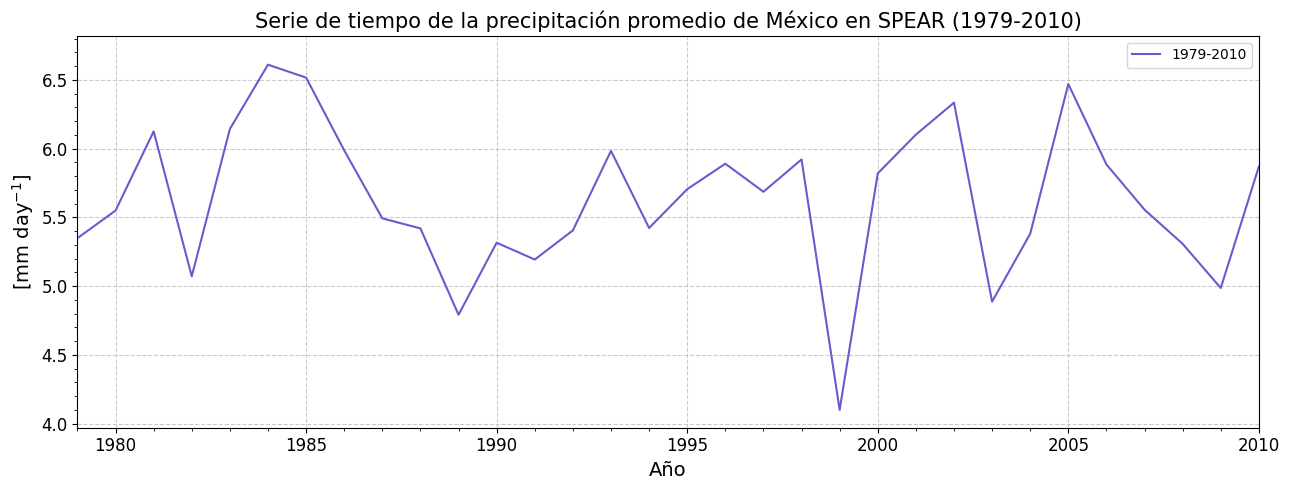

In [19]:
plt.figure(figsize=(13,5))
plt.plot(pr_annual2.time.dt.year,pr_annual2,c='slateblue',label='1979-2010') 
lineplot_setup(1979,2010,'Año','[mm day$^{-1}$]',title='Serie de tiempo de la precipitación promedio de México en SPEAR (1979-2010)')
plt.legend()
plt.tight_layout()

In [20]:
# generar automaticamente la lista de archivos
file_list = np.sort(glob.glob("/home/jovyan/ModClim/SPEAR3/monthly*ens*.nc"))
print(file_list)

['/home/jovyan/ModClim/SPEAR3/monthly_ens001.nc'
 '/home/jovyan/ModClim/SPEAR3/monthly_ens002.nc'
 '/home/jovyan/ModClim/SPEAR3/monthly_ens003.nc']


In [21]:
# almacena los miembros
ens_dlist = []

# Ciclo para cada miembro
for i, filename in enumerate(file_list[:3]):
    ds = xr.open_dataset(filename)
    pr = ds['precip'] * 86400  
    pr['units'] = 'mm day-1'

    # Selección de verano periodo reciente
    pr_years=pr.sel(time=slice('1980', '2010'))
    pr_jjas = pr_years.where((pr.time.dt.month >= 6) & (pr.time.dt.month <= 9), drop=True)

    pr_jjas = pr_jjas.assign_coords(ens=i + 1)
    ens_dlist.append(pr_jjas)
    
    # Append a la lista
ens_combined = xr.concat(ens_dlist, dim='ens')
print(ens_combined)

# Concatena en dimension ens
ens_mean = ens_combined.mean(dim='ens')

<xarray.DataArray 'precip' (ens: 3, time: 124, lat: 90, lon: 104)> Size: 14MB
array([[[[ 0.3105119 ,  0.30919513,  0.3042074 , ...,  7.5636992 ,
           5.9965076 ,  3.622634  ],
         [ 0.27155435,  0.26371098,  0.26977918, ...,  8.700423  ,
           6.670884  ,  4.1860495 ],
         [ 0.25998977,  0.24630693,  0.25352648, ...,  8.865246  ,
           7.8806357 ,  3.7267838 ],
         ...,
         [ 2.2127275 ,  3.3116136 ,  4.118185  , ...,  4.2209206 ,
           4.086631  ,  3.6991665 ],
         [ 1.5890135 ,  2.4290853 ,  3.8041646 , ...,  4.0296187 ,
           3.9055624 ,  3.6128283 ],
         [ 1.269207  ,  1.9695392 ,  2.8774643 , ...,  3.6964366 ,
           3.836139  ,  3.7693894 ]],

        [[ 0.13993429,  0.14175801,  0.11414729, ...,  1.6054577 ,
           1.5571458 ,  1.5586638 ],
         [ 0.14670886,  0.15721141,  0.1369917 , ...,  1.7246947 ,
           1.367789  ,  1.3952038 ],
         [ 0.15723962,  0.16542192,  0.16124693, ...,  1.7828562 ,
       

In [22]:
ens_mean.lon

<xarray.DataArray 'lon' (lon: 104)> Size: 832B
array([235.3125, 235.9375, 236.5625, 237.1875, 237.8125, 238.4375, 239.0625,
       239.6875, 240.3125, 240.9375, 241.5625, 242.1875, 242.8125, 243.4375,
       244.0625, 244.6875, 245.3125, 245.9375, 246.5625, 247.1875, 247.8125,
       248.4375, 249.0625, 249.6875, 250.3125, 250.9375, 251.5625, 252.1875,
       252.8125, 253.4375, 254.0625, 254.6875, 255.3125, 255.9375, 256.5625,
       257.1875, 257.8125, 258.4375, 259.0625, 259.6875, 260.3125, 260.9375,
       261.5625, 262.1875, 262.8125, 263.4375, 264.0625, 264.6875, 265.3125,
       265.9375, 266.5625, 267.1875, 267.8125, 268.4375, 269.0625, 269.6875,
       270.3125, 270.9375, 271.5625, 272.1875, 272.8125, 273.4375, 274.0625,
       274.6875, 275.3125, 275.9375, 276.5625, 277.1875, 277.8125, 278.4375,
       279.0625, 279.6875, 280.3125, 280.9375, 281.5625, 282.1875, 282.8125,
       283.4375, 284.0625, 284.6875, 285.3125, 285.9375, 286.5625, 287.1875,
       287.8125, 288.4375, 289.0625, 289.6875, 290.3125, 290.9375, 291.5625,
       292.1875, 292.8125, 293.4375, 294.0625, 294.6875, 295.3125, 295.9375,
       296.5625, 297.1875, 297.8125, 298.4375, 299.0625, 299.6875])
Coordinates:
  * lon      (lon) float64 832B 235.3 235.9 236.6 237.2 ... 298.4 299.1 299.7
    units    <U8 32B 'mm day-1'
Attributes:
    standard_name:  longitude
    long_name:      longitude
    units:          degrees_E
    axis:           X
    bounds:         lon_bnds

In [24]:
#area_ens = ens_mean.sel(lat=slice(13.75, 22.25), lon=slice(253.4375, 273.4375))
area_ens = ens_mean.sel(lat=slice(10.25, 33.25), lon=slice(241.5625, 275.9375))

mean_annual = area_ens.groupby('time.year').mean(dim='time')

In [25]:
mean_precipitation_ensemble = mean_annual.mean(dim=['lat', 'lon']).values

In [26]:
years = mean_annual['year'].values

In [27]:
# Serie de tiempo
X = years
y = mean_precipitation_ensemble

# Calcular la pendiente y la intersección
m = np.sum((X - np.mean(X)) * (y - np.mean(y))) / np.sum((X - np.mean(X))**2)
b = np.mean(y) - m * np.mean(X)

# predicciones 
predicciones = b + m * X

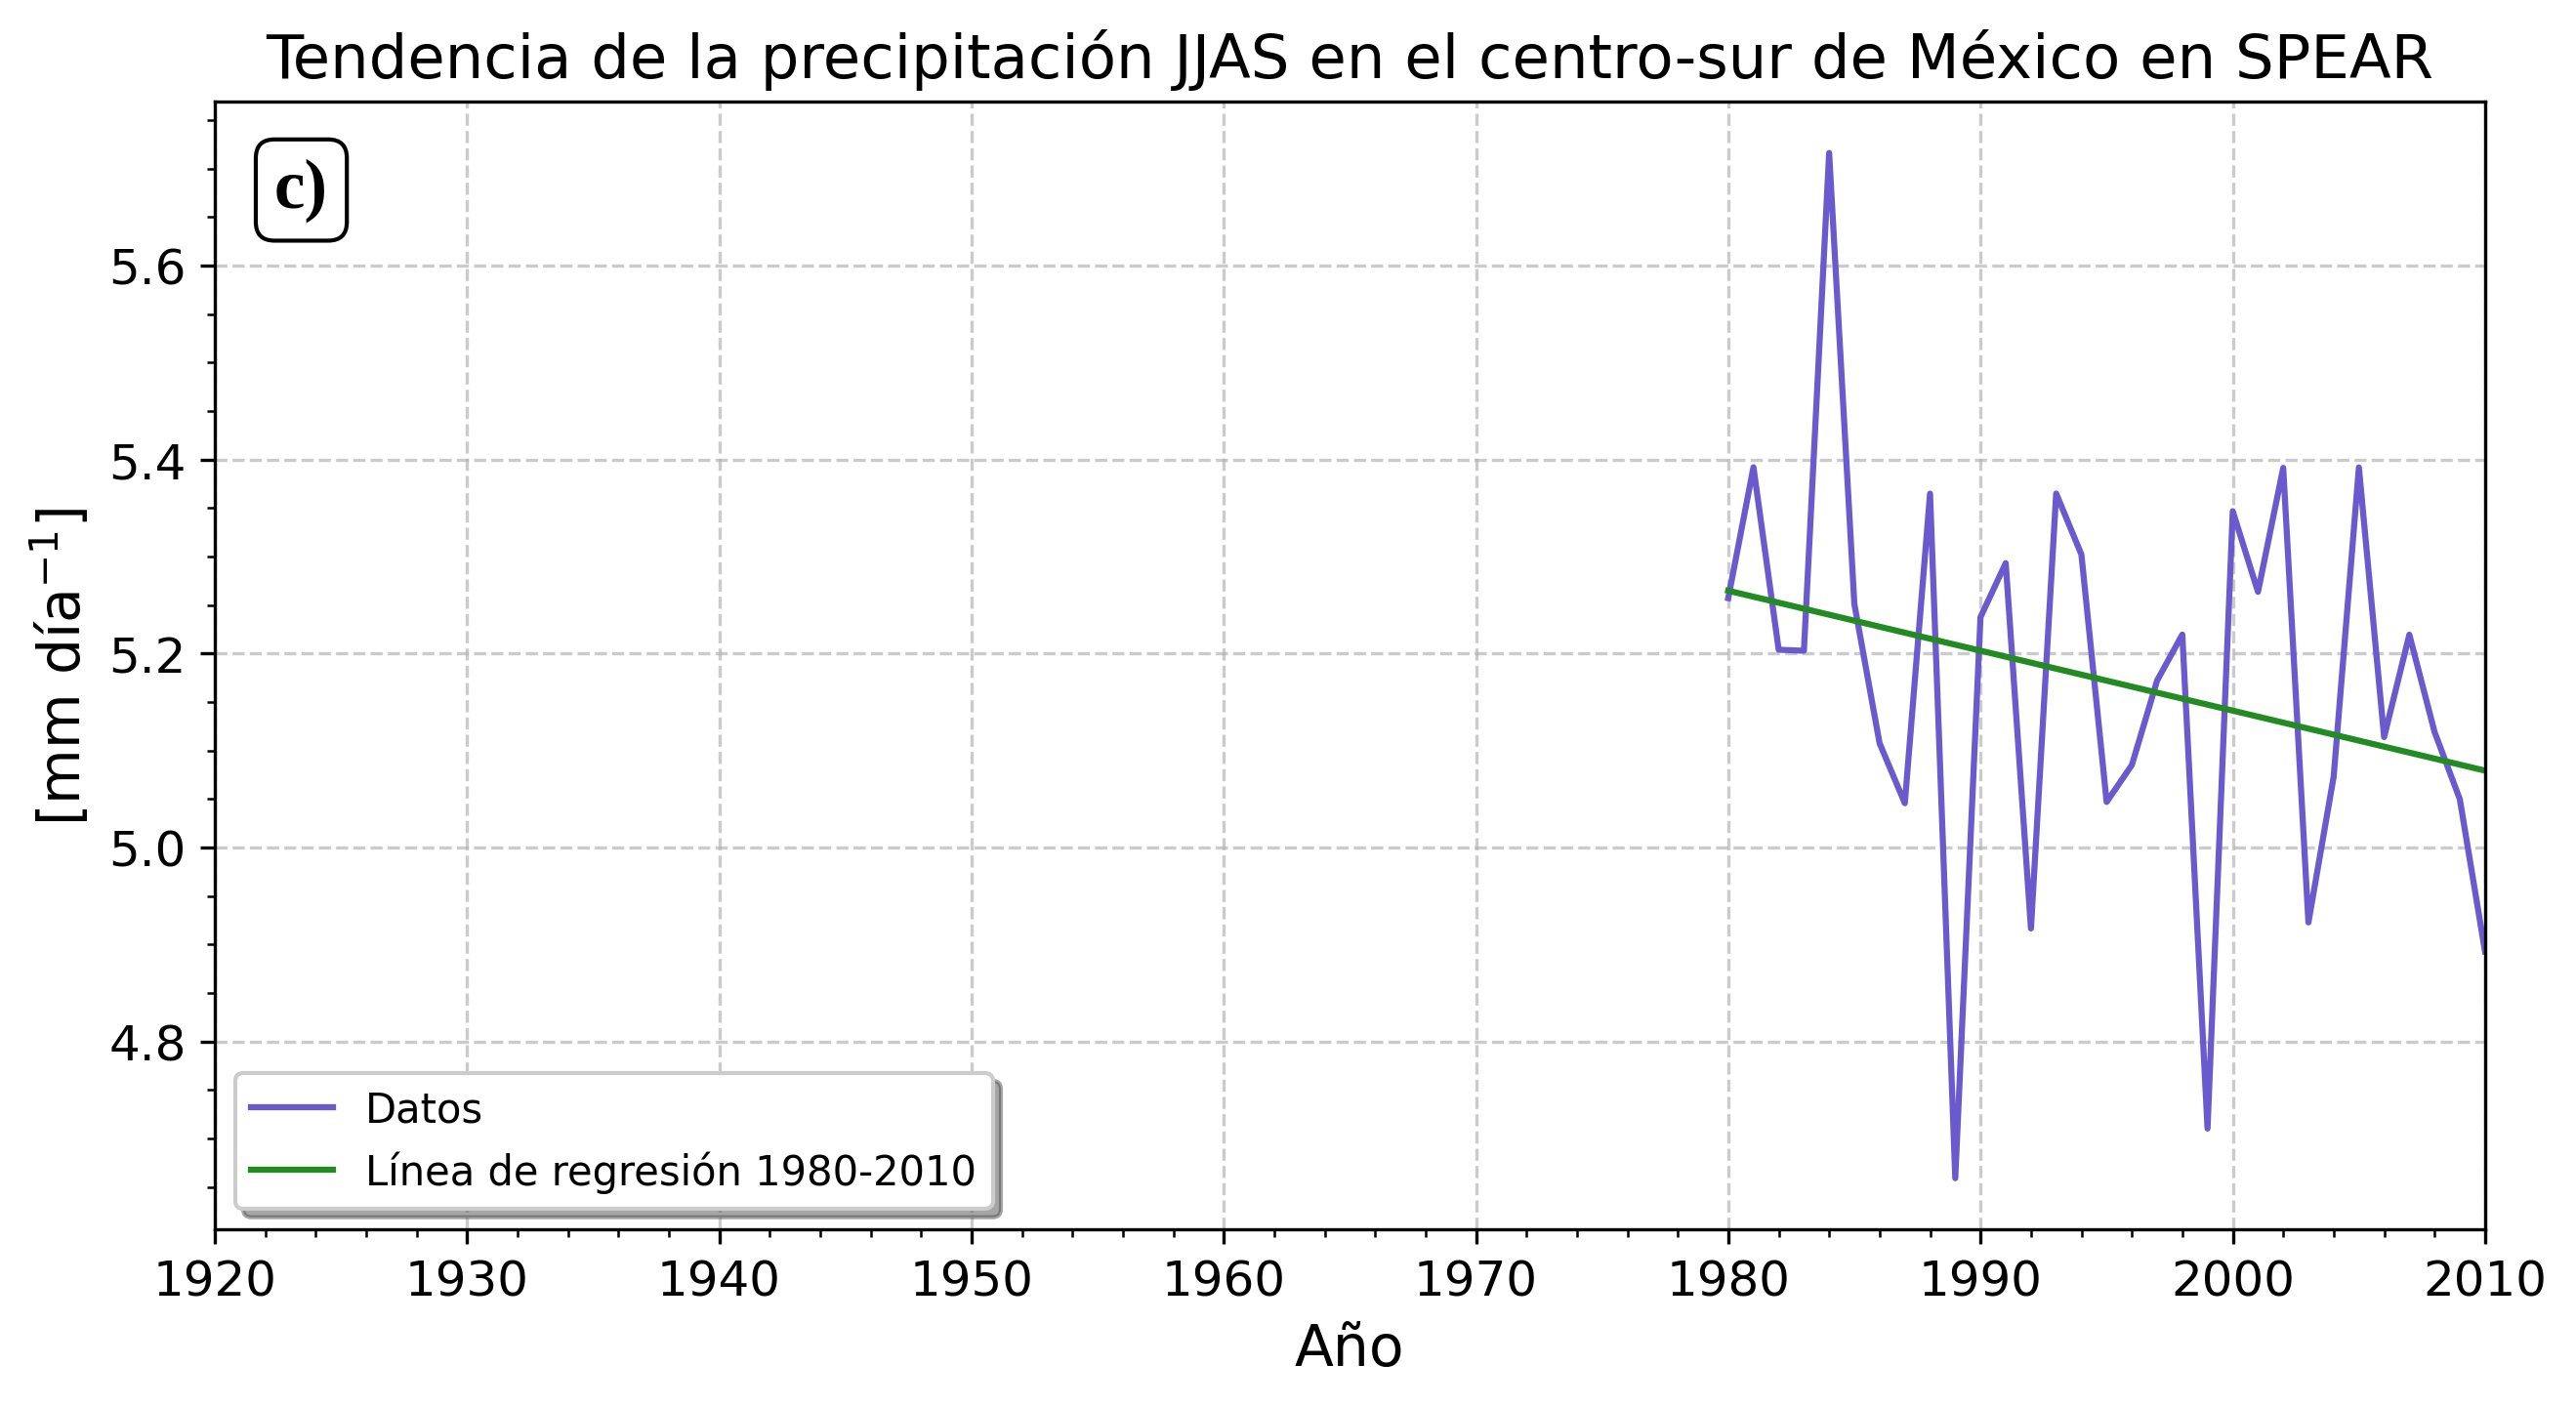

In [28]:
# Graficamos los datos y la línea de regresión
plt.figure(figsize=(10,5), dpi=300)
plt.plot(X, y, color='slateblue', label='Datos')
#plt.plot(X2, y2, color='slateblue', label='Datos')
plt.plot(X, predicciones, color='forestgreen', label='Línea de regresión 1980-2010')
#plt.plot(X2, predicciones2, color='crimson', label='Línea de regresión 1920-2010')
plt.text(0.05, 0.95, 'c)', transform=plt.gca().transAxes, fontsize=17, fontname='Liberation Serif', fontweight='bold', va='top', ha='right',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.27', linewidth=1))
lineplot_setup(1920,2010,'Año','[mm día$^{-1}$]',title='Tendencia de la precipitación JJAS en el centro-sur de México en SPEAR',legend=True)
ax = plt.gca()  # Obtener el eje actual
#ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))  # Intervalo de 0.5 en 0.5

In [29]:
# la funcion para el coeficiente de regresión
def reg_coef(X,y):
    m=np.sum((X - np.mean(X)) * (y - np.mean(y))) / np.sum((X - np.mean(X))**2)
    b = np.mean(y) - m * np.mean(X)
    return m,b

N_ens=len(ens_combined.ens)
# Se inicializa la matriz
print(N_ens)
coef_matriz_m2 = np.zeros((N_ens,len(area_ens.lat), len(area_ens.lon)))
coef_matriz_b2 = np.zeros((N_ens,len(area_ens.lat), len(area_ens.lon)))

for ie,ensemble in enumerate(ens_combined.ens):
    for i, lat in enumerate(area_ens.lat):
        for j, lon in enumerate(area_ens.lon):
            # Calculamos los coeficientes de regresión 
            y = ens_combined.sel(lat=lat, lon=lon,ens=ensemble).groupby('time.year').mean(dim='time').values
            X = years
            m,b = reg_coef(X,y)

            # Guardamos m y b en la matriz
            coef_matriz_m2[ie,i, j] = m
            coef_matriz_b2[ie,i, j] = b
        
coeficientes_promedio=np.mean(coef_matriz_m2,axis=0)

3


In [30]:
# almacenar archivos
ens_dlist = []

# Ciclo para cada archivo
for i, filename in enumerate(file_list):
    ds = xr.open_dataset(filename)
    pr = ds['precip'] * 86400  
    pr['units'] = 'mm day-1'

    # Selección de verano periodo completo
    pr_years2=pr.sel(time=slice('1921', '2010'))
    pr_jjas2 = pr_years2.where((pr.time.dt.month >= 6) & (pr.time.dt.month <= 9), drop=True)


    pr_jjas2 = pr_jjas2.assign_coords(ens=i + 1)
    ens_dlist.append(pr_jjas2)
    
ens_combined2 = xr.concat(ens_dlist, dim='ens')
print(ens_combined2)

# Concatena 
ens_mean2 = ens_combined2.mean(dim='ens')

<xarray.DataArray 'precip' (ens: 3, time: 360, lat: 90, lon: 104)> Size: 40MB
array([[[[ 0.23055   ,  0.19597673,  0.15402772, ..., 14.221833  ,
           8.751894  ,  4.7008224 ],
         [ 0.17870091,  0.1687568 ,  0.13877204, ..., 12.587558  ,
           9.740463  ,  7.553781  ],
         [ 0.14594315,  0.1406652 ,  0.12606521, ..., 12.00389   ,
          12.202474  , 11.282138  ],
         ...,
         [ 1.3080932 ,  1.9023124 ,  2.124213  , ...,  6.920149  ,
           6.985851  ,  6.7509527 ],
         [ 1.1259725 ,  1.6561557 ,  2.2878475 , ...,  5.6570787 ,
           5.795901  ,  6.036526  ],
         [ 1.015633  ,  1.4812825 ,  1.9912394 , ...,  5.023547  ,
           5.1749787 ,  5.2351737 ]],

        [[ 0.22798759,  0.22183172,  0.21115436, ...,  9.086072  ,
          12.243313  , 10.901846  ],
         [ 0.1881542 ,  0.19442214,  0.18841015, ...,  9.922695  ,
          12.6967    , 12.858673  ],
         [ 0.19170591,  0.19291337,  0.20159353, ..., 10.852235  ,
       

In [31]:
area_ens2 = ens_mean2.sel(lat=slice(10.25, 33.25), lon=slice(241.5625, 275.9375))
mean_annual2 = area_ens2.groupby('time.year').mean(dim='time')

In [32]:
mean_precipitation_ensemble_4 = mean_annual2.mean(dim=['lat', 'lon']).values

In [33]:
years_2 = mean_annual2['year'].values

In [34]:
# funcion para coef. de regresión
def reg_coef(X,y):
    m=np.sum((X - np.mean(X)) * (y - np.mean(y))) / np.sum((X - np.mean(X))**2)
    b = np.mean(y) - m * np.mean(X)
    return m,b

N_ens2=len(ens_combined2.ens)

print(N_ens)
coef_matriz_m4 = np.zeros((N_ens2,len(area_ens2.lat), len(area_ens2.lon)))
coef_matriz_b4 = np.zeros((N_ens2,len(area_ens2.lat), len(area_ens2.lon)))

for ie,ensemble in enumerate(ens_combined2.ens):
    for i, lat in enumerate(area_ens2.lat):
        for j, lon in enumerate(area_ens2.lon):
            y = ens_combined2.sel(lat=lat, lon=lon,ens=ensemble).groupby('time.year').mean(dim='time').values
            X = years_2
            m,b = reg_coef(X,y)

            # Guardamos m y b en la matriz
            coef_matriz_m4[ie,i, j] = m
            coef_matriz_b4[ie,i, j] = b
        
coeficientes_promedio_4=np.mean(coef_matriz_m4,axis=0)

3


In [35]:
coeficientes_promedio_da = xr.DataArray(coeficientes_promedio_4, coords={"lat": area_ens2.lat, "lon": area_ens2.lon}, dims=["lat", "lon"])

In [36]:
coeficientes_promedio_80 = xr.DataArray(coeficientes_promedio, coords={"lat": area_ens.lat, "lon": area_ens.lon}, dims=["lat", "lon"])

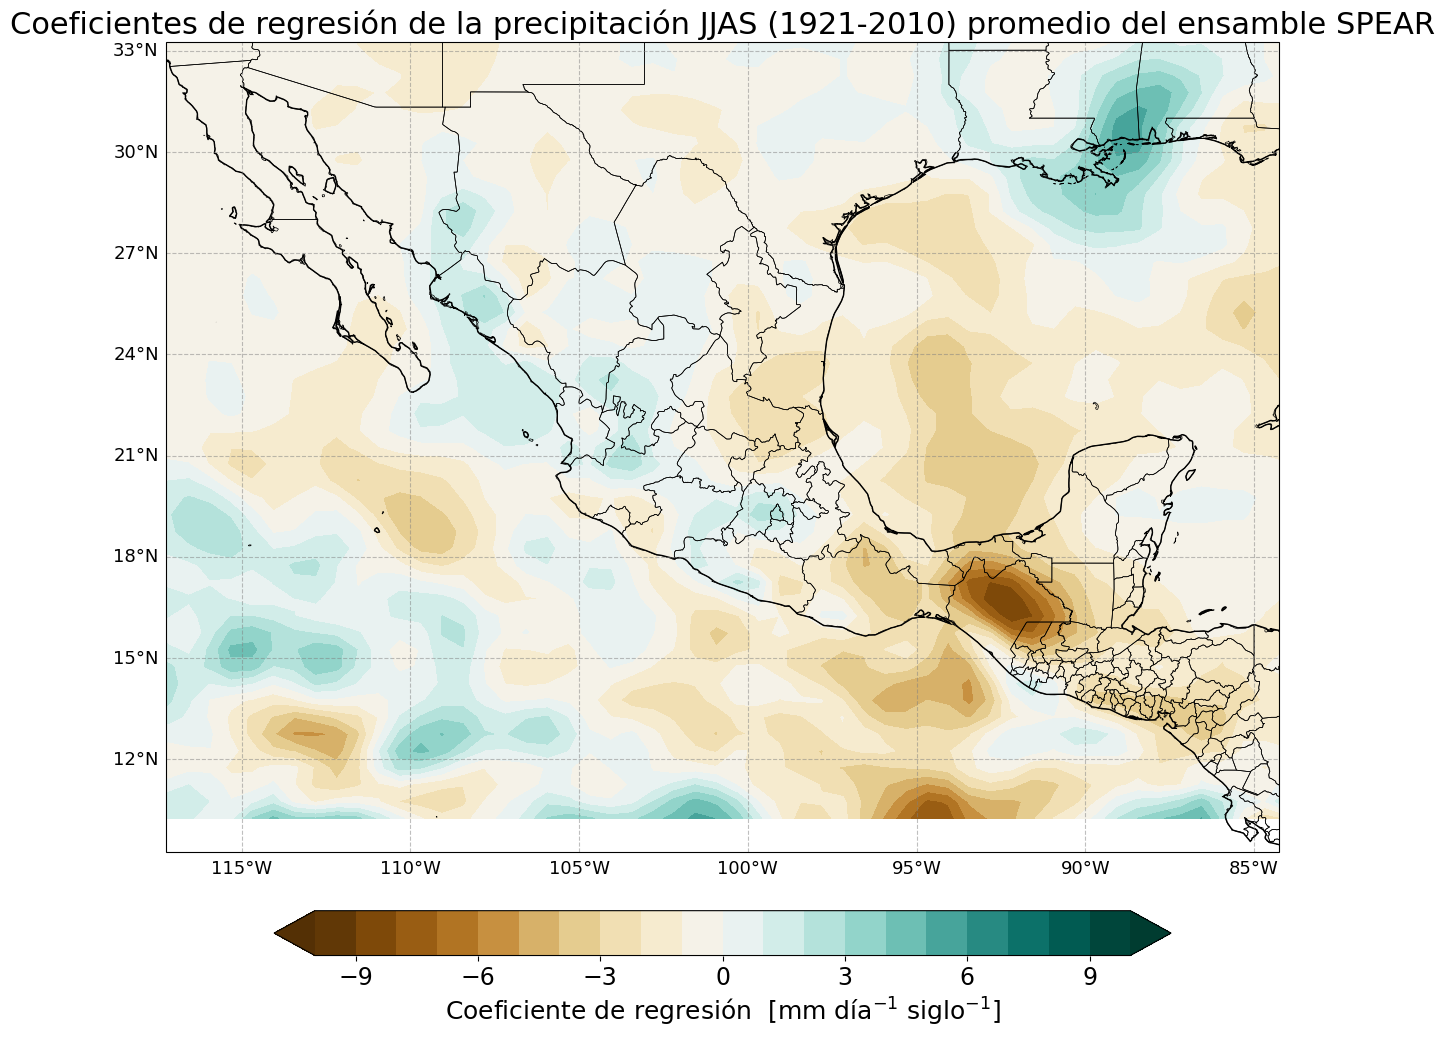

In [37]:
#coef_matriz_m_da2 = xr.DataArray(coeficientes_promedio, coords=[area_ens.lat, area_ens.lon], dims=["lat", "lon"])
#coeficientes_promedio_da.to_netcdf('coeficientes_regresion_SPEAR_80.nc')

levels = np.linspace(-10,10, 21) 

# Graficamos 
mapa_MC(coeficientes_promedio_80*100, levels, 'BrBG', 'Coeficientes de regresión de la precipitación JJAS (1921-2010) promedio del ensamble SPEAR', 
        extend='both', cbarlabel='Coeficiente de regresión  [mm día$^{-1}$ siglo$^{-1}$]', lon_min=242.75, lon_max=275.75, lat_min=9.25, lat_max=33.25)

In [38]:
def mapa_individual_MC(data, levels, ccmap, titulo, extend='max', ax=None, cbarlabel='pr  [mm day$^{-1}$]', 
                         limite_NS=75, lon_min=None, lon_max=None, lat_min=None, lat_max=None):
    # Extraemos las coordenadas 
    lons, lats = data.lon, data.lat
    data, lon = add_cyclic_point(data, coord=lons)
    
    ax.coastlines()
    cs = ax.contourf(lon, lats, data, levels=levels, cmap=ccmap, extend=extend,
                      transform=ccrs.PlateCarree())
    
    # Configuramos extensión
    if lon_min is not None and lon_max is not None and lat_min is not None and lat_max is not None:
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    else:
        ax.set_extent([0, 359.1, -limite_NS, limite_NS], crs=ccrs.PlateCarree())
    
    # Añadimos los detalles de cuadricula y estados
    gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
    ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='k', linewidth=0.5)
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}
    
    ax.set_title(titulo, fontsize=16)

    return cs

In [39]:
# Definimos la función de la cbar
def add_map_colorbar(pos, axis, labelsita, fig, cs):
    cbar_ax = fig.add_axes(axis)  
    cbar = fig.colorbar(cs, cax=cbar_ax, orientation=pos)
    cbar.ax.tick_params(labelsize=12)
    if labelsita is not None:
        cbar.set_label(label=labelsita, fontsize=14)
    return cbar

In [40]:
coef_promedio_1980 = xr.open_dataset("coef_regresion_spear_ens_mean_80_allens.nc")['regression_coeff']
coef_promedio_1921 = xr.open_dataset("coef_regresion_spear_ens_mean_21_allens.nc")['regression_coeff']

#coef_promedio_1980 = xr.open_dataset("coef_regresion_spear_ens_mean_p80.nc")['regression_coeff']
#coef_promedio_1921 = xr.open_dataset("coef_regresion_spear_ens_mean_p21.nc")['regression_coeff']

In [45]:
fig, axs = plt.subplots(4, 2, figsize=(14, 18), dpi=600, subplot_kw={'projection': ccrs.PlateCarree()})

cs_list_1921 = []
cs_list_1980 = []

# Levels para cada periodo
levels_1921 = np.linspace(-3, 3, 21)
#levels_1921_2 = np.linspace(-1.5, 1.5, 21)

levels_1980 = np.linspace(-9, 9, 21)
#levels_1980_2 = np.linspace(-3.5, 3.5, 21)


# ciclo en los 3 miembros para el periodo 1921-2010 (Esto sale en la primera columna)
for ie in range(3):
    coeficientes_da = xr.DataArray(coef_matriz_m4[ie], coords={"lat": area_ens2.lat, "lon": area_ens2.lon}, dims=["lat", "lon"])
    titulo = f'Miembro {ie+1} (1921-2010)'
    cs = mapa_individual_MC(coeficientes_da * 100, levels_1921, 'BrBG', titulo, extend='both', ax=axs[ie, 0],
                            lon_min=242, lon_max=275.75, lat_min=10.25, lat_max=33.25)
    cs_list_1921.append(cs)

# Promedio del ensamble 1921-2010 (Fila 4, Columna 1)
cs = mapa_individual_MC(coef_promedio_1921 * 100, levels_1921, 'BrBG', 'Promedio del ensamble (1921-2010)',
                        extend='both', ax=axs[3, 0], lon_min=242, lon_max=275.75, lat_min=10.25, lat_max=33.25)
cs_list_1921.append(cs)

# ciclo en los 3 miembros para el periodo 1980-2010 (Sale en la segunda columna)
for ie in range(3):
    coeficientes_da_80 = xr.DataArray(coef_matriz_m2[ie], coords={"lat": area_ens.lat, "lon": area_ens.lon}, dims=["lat", "lon"])
    titulo = f'Miembro {ie+1} (1980-2010)'
    cs = mapa_individual_MC(coeficientes_da_80 * 100, levels_1980, 'BrBG', titulo, extend='both', ax=axs[ie, 1],
                            lon_min=242, lon_max=275.75, lat_min=10.25, lat_max=33.25)
    cs_list_1980.append(cs)

# Promedio del ensamble Reciente 1980-2010 (4,2)
cs = mapa_individual_MC(coef_promedio_1980 * 100, levels_1980, 'BrBG', 'Promedio del ensamble (1980-2010)',
                        extend='both', ax=axs[3, 1], lon_min=242, lon_max=275.75, lat_min=10.25, lat_max=33.25)
cs_list_1980.append(cs)

# Cbar Completo 1921-2010 (Primera)
add_map_colorbar('horizontal', [0.15, 0.09, 0.33, 0.009], 'Coeficiente de regresión [mm día$^{-1}$ siglo$^{-1}$]', fig, cs_list_1921[0])

# Cbar Reciente 1980-2010 (Segunda)
add_map_colorbar('horizontal', [0.545, 0.09, 0.33, 0.009], 'Coeficiente de regresión [mm día$^{-1}$ siglo$^{-1}$]', fig, cs_list_1980[0])

fig.subplots_adjust(hspace=0.22, wspace=0.04, bottom=0.12, top=0.92)
#plt.suptitle('Coeficientes de regresión JJAS - Ensamble SPEAR', fontsize=20)
plt.show()